# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [ ]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong

import os
import numpy as np
import pandas as pd
from google.colab import drive
from scipy import signal
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
from scipy.signal import butter, filtfilt, iirnotch
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    """
    Load P300 BCI Competition III data
    Returns dictionary with signal, flashing, stimulus_code, stimulus_type, target_char
    """
    data = sio.loadmat(file_path)
    signal = data.get('Signal')
    flashing = data.get('Flashing')
    stimulus_code = data.get('StimulusCode')
    stimulus_type = data.get('StimulusType')
    target_char = data.get('TargetChar')
    return{'signal': signal , 'flashing': flashing.flatten() , 'stimulus_code': stimulus_code.flatten() ,'stimulus_type': stimulus_type.flatten() ,'target_char': target_char}

    # Training data has labels, test data doesn't


def get_char_from_codes(row_code, col_code):
    """Convert row/column stimulus codes to character"""
    row_idx = int(row_code) - 7
    col_idx = int(col_code) - 1
    return CHAR_MATRIX[row_idx, col_idx]

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
data = load_data(file_path)
print(f"Signal Shape: {data['signal'].shape}")
print(f"Target String: {data['target_char']}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Signal Shape: (85, 7794, 64)
Target String: ['EAEVQTDOJG8RBRGONCEDHCTUIDBPUHMEM6OUXOCFOUKWA4VJEFRZROLHYNQDW_EKTLBWXEPOUIKZERYOOTHQI']


In [ ]:
print(data.keys())

dict_keys(['signal', 'flashing', 'stimulus_code', 'stimulus_type', 'target_char'])


P300 Analysis Results
Mean Amplitude in Target: 5.734797015096131
Mean Amplitude in Non-Target: -0.37933011610741363
Difference in Mean Amplitudes: 6.114127131203545


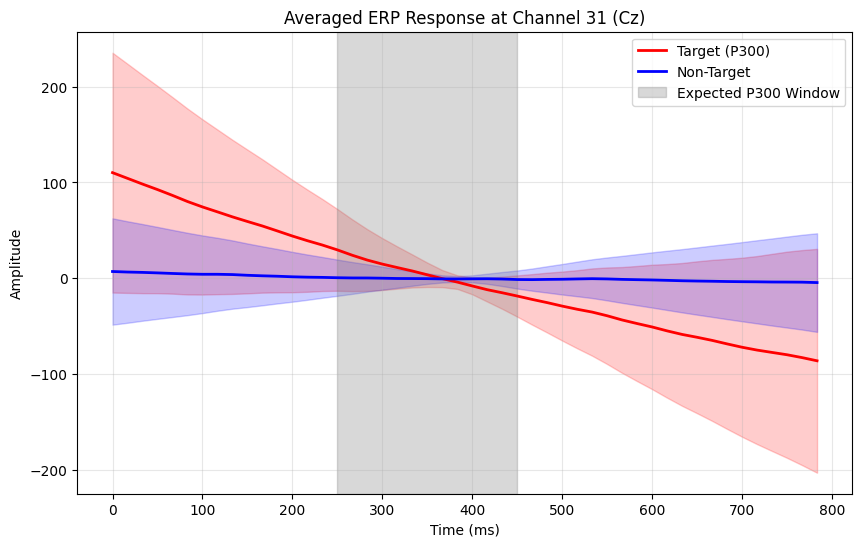

In [ ]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################

def bandpass_filter(signal_data, lowcut=0.1, highcut=20, fs=240, order=5):
    """
    Apply band-pass filter to remove low-frequency drift and high-frequency noise
    Typical P300 band: 0.1-20 Hz
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal_data, axis=1)

def notch_filter(signal_data, freq=50, fs=240, Q=30):
    """
    Remove powerline interference (50/60 Hz)
    """
    w0 = freq / (0.5 * fs)
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal_data, axis=1)

def baseline_correction(epoch, baseline_samples=50):
    """
    Apply baseline correction by subtracting pre-stimulus baseline
    """
    baseline = np.mean(epoch[:baseline_samples, :], axis=0)
    return epoch - baseline

def downsample_signal(signal_data, original_fs=240, target_fs=60):
    """
    Downsample signal to reduce computational load
    240 Hz -> 60 Hz reduces data by 4x
    """
    factor = int(original_fs / target_fs)
    return signal.decimate(signal_data, factor, axis=1)

def artifact_rejection(signal_data, threshold=100):
    """
    Simple artifact rejection based on amplitude threshold
    More advanced: use ICA or wavelet denoising
    """
    mask = np.any(np.abs(signal_data) > threshold, axis=(1, 2))
    return signal_data , mask

def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, fs=240):
    """
    Complete preprocessing pipeline:
    1. Bandpass filtering (0.1-20 Hz)
    2. Notch filtering (50 Hz)
    3. Downsampling (240->60 Hz)
    """

    sig = data
    if apply_bandpass:
        sig = bandpass_filter(sig,fs=fs)
    if apply_notch:
        sig = notch_filter(sig,fs=fs)
    if apply_downsample:
        sig = downsample_signal(sig, original_fs=fs, target_fs=60)
    return sig

def extract_epochs(data,preprocessed_sig, epoch_length_ms=800, fs=60):
    """
    Extract epochs around stimulus onset
    - Event tagging: Use flashing signal to detect stimulus onset
    - Stimulus alignment: Extract fixed-length windows after each flash
    - Epoch extraction: Collect all stimulus-locked epochs
    Returns: Dictionary with epochs, labels, codes, character indices
    """
    samples_per_epoch = int((epoch_length_ms / 1000)*fs)
    if preprocessed_sig.ndim == 3:
      preprocessed_sig = preprocessed_sig.reshape(-1, preprocessed_sig.shape[-1])
    flashing = data['flashing'].flatten()
    stimulus_code = data['stimulus_code'].flatten()

    has_stimulus_type = data['stimulus_type'] is not None
    if has_stimulus_type:
        stimulus_type = data['stimulus_type'].flatten()
    else:
        stimulus_type = np.array([]) # Empty array if no stimulus type, for consistency

    # all_targets = data['target_char'] # Not used in this function for processing, can be ignored for now
    epochs, labels, codes_list = [], [], []
    onsets = np.where(np.diff(flashing, prepend=0) == 1)[0]
    for onset in  onsets:
      epoch = preprocessed_sig[onset : onset + samples_per_epoch, :]
      if epoch.shape[0] != samples_per_epoch:
        continue
      if np.max(np.abs(epoch)) > 20000:
        continue
      epoch = baseline_correction(epoch, baseline_samples=50)
      epochs.append(epoch)
      if has_stimulus_type:
          labels.append(stimulus_type[onset])
      codes_list.append(stimulus_code[onset])

    return {
        'epochs': epochs,
        'labels': np.array(labels) if has_stimulus_type else np.array([]),
        'codes': np.array(codes_list),
    }

def plot_erp_responses(epoch_data, channel_idx=31, fs=60):
    """
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """
    epochs = np.array(epoch_data['epochs'])
    labels = np.array(epoch_data['labels'])

    if labels.size == 0:
        print("No labels available for ERP plotting (e.g., test data). Skipping ERP plot.")
        return

    channel_data = epochs[:, :, channel_idx]

    target_trials = channel_data[labels == 1]
    non_target_trials = channel_data[labels == 0]

    # Plot averages with standard error
    target_mean = np.mean(target_trials, axis=0)
    non_target_mean = np.mean(non_target_trials, axis=0)

    target_sem = np.std(target_trials, axis=0) / np.sqrt(len(target_trials))
    non_target_sem = np.std(non_target_trials, axis=0) / np.sqrt(len(non_target_trials))

    num_samples = target_mean.shape[0]
    time_points = np.arange(num_samples)*(1000/fs)
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, target_mean, color='red', label='Target (P300)', linewidth=2)
    plt.fill_between(time_points, target_mean - target_sem, target_mean + target_sem, color='red', alpha=0.2)
    plt.plot(time_points, non_target_mean, color='blue', label='Non-Target', linewidth=2)
    plt.fill_between(time_points, non_target_mean - non_target_sem, non_target_mean + non_target_sem, color='blue', alpha=0.2)

    # Mark P300 peak region
    p300_start_ms, p300_end_ms = 250, 450
    plt.axvspan(p300_start_ms, p300_end_ms, color='gray', alpha=0.3, label='Expected P300 Window')
    plt.title(f"Averaged ERP Response at Channel {channel_idx} (Cz)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Calculate P300 amplitude difference
    idx_start = int(p300_start_ms / 1000 * fs)
    idx_end = int(p300_end_ms / 1000 * fs)
    mean_amp_target = np.mean(target_mean[idx_start:idx_end])
    mean_amp_nontarget = np.mean(non_target_mean[idx_start:idx_end])
    diff = mean_amp_target - mean_amp_nontarget
    print(f"P300 Analysis Results")
    print(f"Mean Amplitude in Target: {mean_amp_target}")
    print(f"Mean Amplitude in Non-Target: {mean_amp_nontarget}")
    print(f"Difference in Mean Amplitudes: {diff}")

    plt.show()
raw_signals = data['signal']
preprocessed_sig = preprocess_pipeline(raw_signals, fs=240)
epoch_data = extract_epochs(data, preprocessed_sig, epoch_length_ms=800, fs=60)
plot_erp_responses(epoch_data=epoch_data, channel_idx=31, fs=60)

In [ ]:
print(epoch_data.keys())

dict_keys(['epochs', 'labels', 'codes'])


Target epochs for CSP: 123
Non-target epochs for CSP: 624
lda classifier trained
logistic regression classifier trained
lda classifier trained
CSP + LDA Accuracy: 0.6333
CSP + LDA AUC: 0.4298
              precision    recall  f1-score   support

  non-target       0.81      0.73      0.77       125
      target       0.11      0.16      0.13        25

    accuracy                           0.63       150
   macro avg       0.46      0.44      0.45       150
weighted avg       0.69      0.63      0.66       150



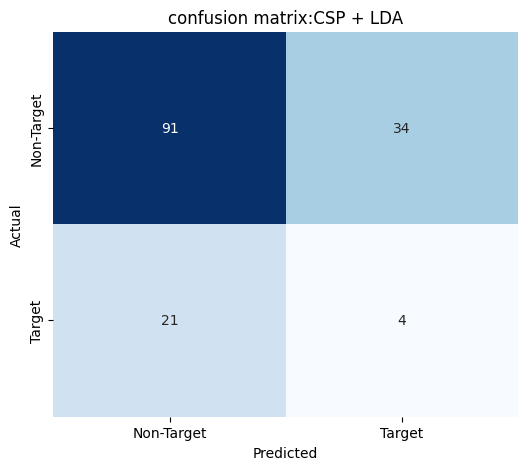

(0.6333333333333333, np.float64(0.42976))

In [ ]:
################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

def extract_time_domain_features(epochs):
    """
    Extract time-domain features: simply flatten the epochs
    Shape: (n_epochs, n_samples * n_channels)
    """
    n_epochs = epochs.shape[0]
    n_samples = epochs.shape[1]
    n_channels = epochs.shape[2]
    epochs.reshape(n_epochs, n_samples * n_channels)
    return epochs.reshape(n_epochs, n_samples * n_channels)

def extract_pca_features(epochs, n_components=20):
    """
    Extract PCA features for dimensionality reduction
    Reduces (n_samples * n_channels) to n_components
    https://www.geeksforgeeks.org/machine-learning/implementing-pca-in-python-with-scikit-learn/
    """
    pca = PCA(n_components=n_components)
    features = pca.fit_transform(epochs.reshape(epochs.shape[0], -1))
    return features

def extract_csp_features(epochs, labels, n_components=6):
  """
  Common Spatial Patterns (CSP) for discriminative spatial filters
  Finds spatial filters that maximize variance ratio between classes
  """
  target_epochs = epochs[labels == 1]
  non_target_epochs = epochs[labels == 0]
  print(f"Target epochs for CSP: {len(target_epochs)}")
  print(f"Non-target epochs for CSP: {len(non_target_epochs)}")

  #Compute covariance matrices
  def compute_cov(data):
    data = np.transpose(data, (0, 2, 1))
    covs = []
    for i in data:
      cov = np.dot(i, i.T)
      cov = cov/np.trace(cov)
      covs.append(cov)
    return np.mean(covs, axis = 0)
  cov_target = compute_cov(target_epochs)
  cov_non_target = compute_cov(non_target_epochs)
  # Solve generalized eigenvalue problem
  eigenvalues, eigenvectors = eigh(cov_target, cov_target + cov_non_target)
  # Sort by eigenvalues
  ix = np.argsort(eigenvalues)[::-1]
  eigenvectors = eigenvectors[:, ix]
  # Select most discriminative components (extreme eigenvalues)
  n_filters = n_components // 2
  filters = np.concatenate((eigenvectors[:, :n_filters], eigenvectors[:, -n_filters:]), axis=1)
  # Extract CSP features (log variance)
  epochs_transpoted = np.transpose(epochs, (0, 2, 1))
  csp_features = []
  for epoch in epochs_transpoted:
    projected = np.dot(filters.T, epoch)
    varience = np.var(projected, axis=1)
    log_varience = np.log(varience)
    csp_features.append(log_varience)
  return np.array(csp_features)

def extract_features(epoch_data,labels = None, method='pca', n_components=20):
    """
    Feature extraction wrapper supporting multiple methods:
    - time_domain: Raw time-domain samples (flattened)
    - pca: Principal Component Analysis
    - csp: Common Spatial Patterns
    """
    if method == 'time':
        n_epochs = epoch_data.shape[0]
        return epoch_data.reshape(n_epochs, -1)
    elif method == 'pca':
        n_epochs = epoch_data.shape[0]
        flattened_data = epoch_data.reshape(n_epochs, -1)
        pca = PCA(n_components=n_components)
        return pca.fit_transform(flattened_data)
    elif method == 'csp':
      if labels is None:
        raise ValueError("CSP method requires 'labels' to compute spatial filters.")
      return extract_csp_features(epoch_data,labels, n_components=n_components)
    else:
      raise ValueError(f"Unknown feature extraction method: {method}")

def train_lda_classifier(X_train, y_train,balance_priors = True):
    """
    Linear Discriminant Analysis with balanced priors
    https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    """
    priors = [0.5, 0.5] if balance_priors else None
    clf = LinearDiscriminantAnalysis(solver = 'lsqr' ,shrinkage = 'auto' , priors=priors)
    clf.fit(X_train, y_train)
    print("lda classifier trained")
    return clf

def train_logistic_regression(X_train, y_train):
    """
    Logistic Regression - baseline classifier
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    """
    clf = LogisticRegression(class_weight = 'balanced' , solver = 'liblinear' ,max_iter=1000, random_state = 42)
    clf.fit(X_train, y_train)
    print("logistic regression classifier trained")
    return clf

def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive classifier evaluation
    """
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
      y_prob = model.decision_function(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"{model_name} Accuracy: {acc:.4f}")
    print(f"{model_name} AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred, target_names = ['non-target','target']))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar = False,xticklabels=['Non-Target', 'Target'], yticklabels=['Non-Target', 'Target'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'confusion matrix:{model_name}')
    plt.show()
    return acc, auc

class CSPTransformer:
    """
    Wrapper for CSP filters to enable transform() method
    """
    def __init__(self, n_components = 6 ):
        self.n_components = n_components
        self.filters_ = None

    def fit(self, X, y):
        target_epochs = X[y == 1]
        non_target_epochs = X[y == 0]
        cov_target = self._compute_cov(target_epochs)
        cov_non_target = self._compute_cov(non_target_epochs)
        eigenvalues, eigenvectors = eigh(cov_target, cov_target + cov_non_target)
        ix = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, ix]
        n_filters = self.n_components // 2
        self.filters_ = np.concatenate((eigenvectors[:, :n_filters], eigenvectors[:, -n_filters:]), axis=1)
        return self
    def transform(self, X):
        if self.filters_ is None:
            raise RuntimeError("CSPTransformer must be fitted before transforming data.")
        X_transpoted = np.transpose(X, (0, 2, 1))
        csp_features = []
        for epoch in X_transpoted:
          projected = np.dot(self.filters_.T, epoch)
          log_varience = np.log(np.var(projected, axis=1))
          csp_features.append(log_varience)
        return np.array(csp_features)
    def _compute_cov(self, data):
      data = np.transpose(data, (0, 2, 1))
      covs = [np.dot(epoch, epoch.T) / np.trace(np.dot(epoch, epoch.T)) for epoch in data]
      return np.mean(covs, axis = 0)
X = np.array(epoch_data['epochs'])
y = np.array(epoch_data['labels'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_time = extract_time_domain_features(X)
X_csp = extract_csp_features(X, y, n_components=6)
X_features = extract_features(X, method='pca', n_components=20)
lda_model = train_lda_classifier(X_features, y, balance_priors = True)
lr_model = train_logistic_regression(X_features, y)
csp = CSPTransformer(n_components=6)
csp.fit(X_train, y_train)
X_train_csp = csp.transform(X_train)
X_test_csp = csp.transform(X_test)
lda = train_lda_classifier(X_train_csp, y_train)
evaluate_classifier(lda, X_test_csp, y_test, model_name = "CSP + LDA")

SVM classifier trained 
CSP +SVM Accuracy: 0.5800
CSP +SVM AUC: 0.3792
              precision    recall  f1-score   support

  non-target       0.80      0.66      0.72       125
      target       0.09      0.16      0.11        25

    accuracy                           0.58       150
   macro avg       0.44      0.41      0.42       150
weighted avg       0.68      0.58      0.62       150



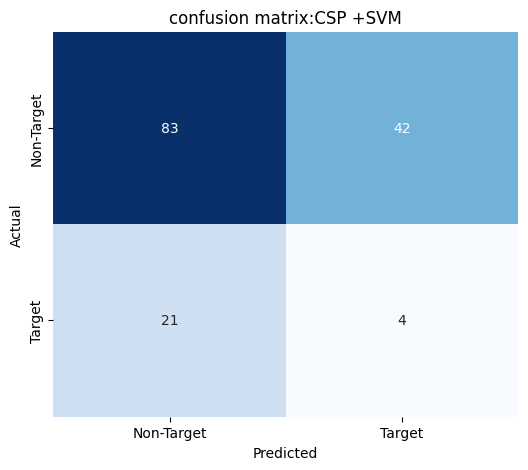

Random Forest classifier trained
CSP + RF Accuracy: 0.8200
CSP + RF AUC: 0.4240
              precision    recall  f1-score   support

  non-target       0.84      0.98      0.90       125
      target       0.25      0.04      0.07        25

    accuracy                           0.82       150
   macro avg       0.54      0.51      0.48       150
weighted avg       0.74      0.82      0.76       150



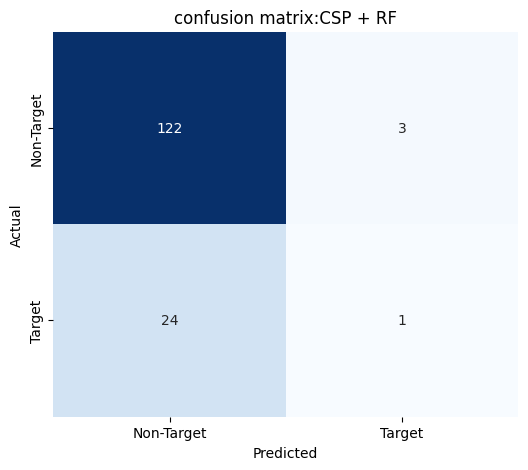


  Training LDA...
lda classifier trained

  Training Logistic Regression...
logistic regression classifier trained

  Training SVM...
SVM classifier trained 

  Training Random Forest...
Random Forest classifier trained

  Training Gradient Boosting...

  Training Gradient Boosting (n_estimators=100)...
gradient boosting trained
                 Model  Accuracy  ROC-AUC
1  Logistic Regression  0.606667  0.44768
0                  LDA  0.633333  0.42976
3        Random Forest  0.820000  0.42400
4    Gradient Boosting  0.633333  0.41120
2                  SVM  0.580000  0.37920


In [ ]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
  """
  Support Vector Machine with RBF kernel
  Good for non-linear decision boundaries
  https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
  """
  clf = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=C, class_weight = 'balanced', probability = True, random_state = 42))
  clf.fit(X_train, y_train)
  print("SVM classifier trained ")
  return clf

def train_random_forest(X_train, y_train, n_estimators=100):
  """
  Random Forest Classifier
  Ensemble method, robust to overfitting
  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
  """
  clf =  RandomForestClassifier(n_estimators=n_estimators, class_weight = 'balanced', random_state = 42)
  clf.fit(X_train, y_train)
  print("Random Forest classifier trained")
  return clf

def train_gradient_boosting(X_train, y_train, n_estimators=100):
  """
  Gradient Boosting Classifier with manual sample weighting
  (GradientBoosting doesn't support class_weight parameter)
  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
  """
  print(f"\n  Training Gradient Boosting (n_estimators={n_estimators})...")
  # Calculate sample weights manually
  weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
  clf = GradientBoostingClassifier(n_estimators=n_estimators,learning_rate = 0.1, max_depth = 3, random_state=42)
  clf.fit(X_train, y_train, sample_weight = weights)
  print("gradient boosting trained")
  return clf

def compare_all_classical_models(X_train, y_train, X_test, y_test):
  """
  Train and compare all classical ML models
  Returns performance comparison and trained models
  """
  # define models to train
  model_functions = {
        "LDA": lambda: train_lda_classifier(X_train, y_train),
        "Logistic Regression": lambda: train_logistic_regression(X_train, y_train),
        "SVM": lambda: train_svm_classifier(X_train, y_train),
        "Random Forest": lambda: train_random_forest(X_train, y_train),
        "Gradient Boosting": lambda: train_gradient_boosting(X_train, y_train)
    }
  results = []
  trained_models = {}
  for model_name, model_func in model_functions.items():
    print(f"\n  Training {model_name}...")
    model = model_func()
    trained_models[model_name] = model # Store the trained model
    # Inference
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
      y_prob = model.predict_proba(X_test)[:, 1]
    else:
      y_prob = model.decision_function(X_test)
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append({
            "Model": model_name,
            "Accuracy": acc,
            "ROC-AUC": auc
        })
  results_df = pd.DataFrame(results)
  results_df = results_df.sort_values(by="ROC-AUC", ascending=False)
  print(results_df)
  return results_df, trained_models # Return both results and models

def save_model(model, filepath):
    """
Save model to pickle file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    """
Load model from pickle file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model
svm_model = train_svm_classifier(X_train_csp, y_train, kernel = 'rbf', C = 1.0)
evaluate_classifier(svm_model, X_test_csp, y_test, model_name = "CSP +SVM")
rf_model = train_random_forest(X_train_csp, y_train, n_estimators=100)
evaluate_classifier(rf_model, X_test_csp, y_test, model_name = "CSP + RF")
df_results, _ = compare_all_classical_models(X_train_csp, y_train, X_test_csp, y_test)

In [ ]:
# ========================================================================
# STEP 1: LOAD DATA
# ========================================================================
import scipy.io
print("\n" + "="*70)
print("STEP 1: LOADING DATA")
print("="*70)

from google.colab import drive

drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/BCI_Comp_III_Wads_2004/'
'/content/drive/My Drive/BCI_Comp_III_Wads_2004/Subject_A_Train.mat'
def load_data(filepath):
    mat = scipy.io.loadmat(filepath)
    return mat

# Load data

train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')
test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')
train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')
test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')



STEP 1: LOADING DATA
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ========================================================================
# STEP 2: PREPROCESSING
# ========================================================================
print("\n" + "="*70)
print("STEP 2: PREPROCESSING")
print("="*70)
print("\n--- Subject A ---")
train_proc_A = preprocess_pipeline(train_data_A['Signal'])
test_proc_A = preprocess_pipeline(test_data_A['Signal'])
print("\n--- Subject B ---")
train_proc_B = preprocess_pipeline(train_data_B['Signal'])
test_proc_B = preprocess_pipeline(test_data_B['Signal'])


STEP 2: PREPROCESSING

--- Subject A ---

--- Subject B ---


In [ ]:
# ========================================================================
# STEP 3: EPOCH EXTRACTION
# ========================================================================
print("\n" + "="*70)
print("STEP 3: EPOCH EXTRACTION")
print("="*70)

def format_mat_data_for_epochs(mat_data):
    """Converts raw .mat dictionary to the format expected by extract_epochs."""
    return {
        'signal': mat_data.get('Signal'),
        'flashing': mat_data.get('Flashing').flatten() if mat_data.get('Flashing') is not None else None,
        'stimulus_code': mat_data.get('StimulusCode').flatten() if mat_data.get('StimulusCode') is not None else None,
        'stimulus_type': mat_data.get('StimulusType').flatten() if mat_data.get('StimulusType') is not None else None,
        'target_char': mat_data.get('TargetChar') # This might be a list or array, leave as is
    }

print("\n--- Subject A ---")
train_epochs_A = extract_epochs(format_mat_data_for_epochs(train_data_A), train_proc_A)
test_epochs_A = extract_epochs(format_mat_data_for_epochs(test_data_A), test_proc_A)

print("\n--- Subject B ---")
train_epochs_B = extract_epochs(format_mat_data_for_epochs(train_data_B), train_proc_B)
test_epochs_B = extract_epochs(format_mat_data_for_epochs(test_data_B), test_proc_B)


STEP 3: EPOCH EXTRACTION

--- Subject A ---

--- Subject B ---



STEP 4: VISUALIZING ERP RESPONSES

--- Subject A ---
P300 Analysis Results
Mean Amplitude in Target: 5.734797015096131
Mean Amplitude in Non-Target: -0.37933011610741363
Difference in Mean Amplitudes: 6.114127131203545


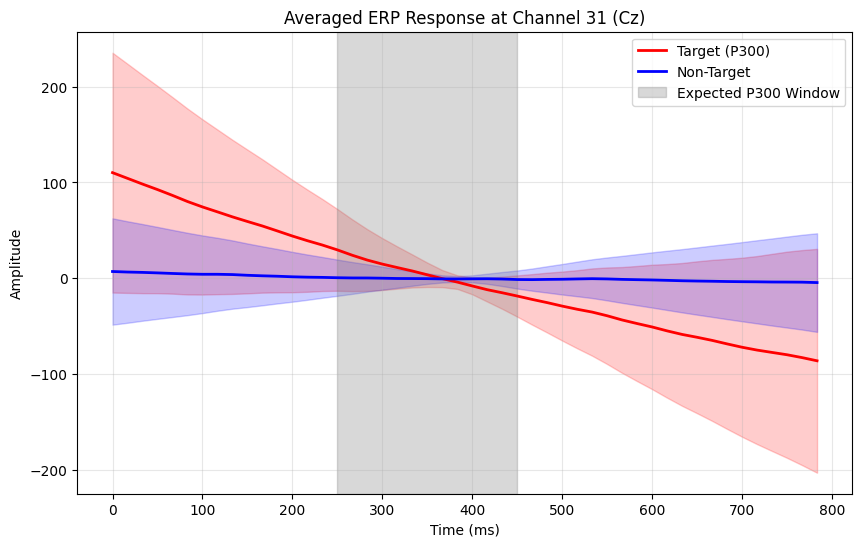

In [ ]:
# ========================================================================
# STEP 4: VISUALIZE ERP
# ========================================================================
print("\n" + "="*70)
print("STEP 4: VISUALIZING ERP RESPONSES")
print("="*70)

print("\n--- Subject A ---")
plot_erp_responses(train_epochs_A, channel_idx=31)


STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---
lda classifier trained
LDA with PCA-20 Accuracy: 0.5600
LDA with PCA-20 AUC: 0.5178
              precision    recall  f1-score   support

  non-target       0.83      0.59      0.69       125
      target       0.16      0.40      0.23        25

    accuracy                           0.56       150
   macro avg       0.50      0.50      0.46       150
weighted avg       0.72      0.56      0.62       150



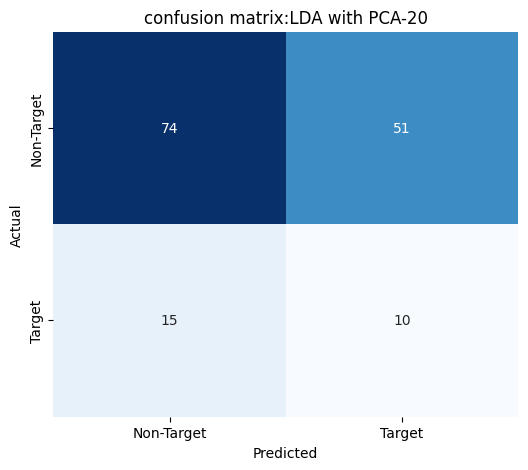

lda classifier trained
LDA with PCA-50 Accuracy: 0.5067
LDA with PCA-50 AUC: 0.4000
              precision    recall  f1-score   support

  non-target       0.79      0.55      0.65       125
      target       0.11      0.28      0.16        25

    accuracy                           0.51       150
   macro avg       0.45      0.42      0.41       150
weighted avg       0.68      0.51      0.57       150



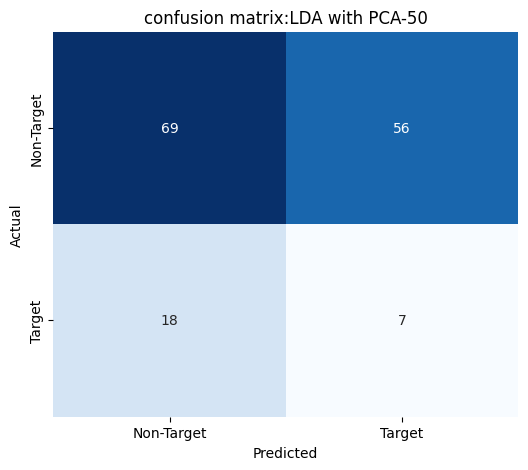

lda classifier trained
LDA with CSP Accuracy: 0.6333
LDA with CSP AUC: 0.4298
              precision    recall  f1-score   support

  non-target       0.81      0.73      0.77       125
      target       0.11      0.16      0.13        25

    accuracy                           0.63       150
   macro avg       0.46      0.44      0.45       150
weighted avg       0.69      0.63      0.66       150



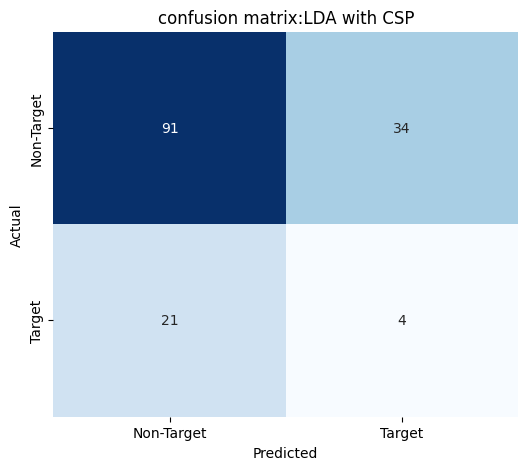

lda classifier trained
LDA with Time-Domain Accuracy: 0.5800
LDA with Time-Domain AUC: 0.4787
              precision    recall  f1-score   support

  non-target       0.84      0.62      0.71       125
      target       0.17      0.40      0.24        25

    accuracy                           0.58       150
   macro avg       0.50      0.51      0.48       150
weighted avg       0.73      0.58      0.63       150



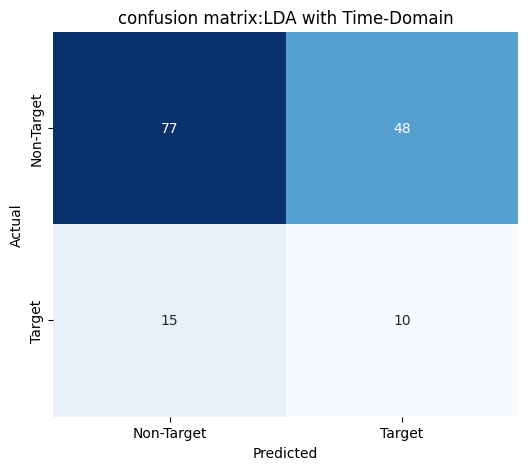


FEATURE COMPARISON (Balanced Classifiers)
PCA (20 comp):      Accuracy=0.5600, AUC=0.5178
PCA (50 comp):      Accuracy=0.5067, AUC=0.4000
CSP (6 comp):       Accuracy=0.6333, AUC=0.4298
Time-Domain (3072): Accuracy=0.5800, AUC=0.4787

Selected best feature extraction method for Subject A: PCA20 with AUC=0.5178

Subject A splits: Training=597, Validation=150
Test features: (969, 20)

--- Subject B: Feature Extraction ---

Using PCA20 (same as Subject A)...
Subject B splits: Training=688, Validation=172
Test features: (972, 20)


In [ ]:
import numpy as np
# ========================================================================
# STEP 5: FEATURE EXTRACTION
# ========================================================================
print("\n" + "="*70)
print("STEP 5: FEATURE EXTRACTION")
print("="*70)
# ========================================================================
# Subject A: Compare PCA vs CSP vs Time-Domain
# ========================================================================
print("\n--- Subject A: Feature Comparison ---")
# Try PCA (20 components)
# Try PCA (50 components)
# Try CSP
# Try Raw Time-Domain Features
# Flatten epochs: (n_epochs, n_samples, n_channels) -> (n_epochs, n_samples * n_channels)
X_flat_A = np.array(train_epochs_A['epochs']).reshape(len(train_epochs_A['epochs']), -1)
y_A = train_epochs_A['labels']
X_tr_flat, X_v_flat, y_tr, y_v = train_test_split(X_flat_A, y_A, test_size=0.2, random_state=42, stratify=y_A)

# Quick comparison with BALANCED LDA
# PCA-20 test
pca20 = PCA(n_components=20)
X_tr_pca20 = pca20.fit_transform(X_tr_flat)
X_v_pca20  = pca20.transform(X_v_flat)
lda_pca20 = train_lda_classifier(X_tr_pca20, y_tr, balance_priors=True)
acc_pca20, auc_pca20 = evaluate_classifier(lda_pca20, X_v_pca20, y_v, model_name="LDA with PCA-20")

# PCA-50 test
pca50 = PCA(n_components=50)
X_tr_pca50 = pca50.fit_transform(X_tr_flat)
X_v_pca50  = pca50.transform(X_v_flat)
lda_pca50 = train_lda_classifier(X_tr_pca50, y_tr, balance_priors=True)
acc_pca50, auc_pca50 = evaluate_classifier(lda_pca50, X_v_pca50, y_v, model_name="LDA with PCA-50")

# CSP test
X_3d_A = np.array(train_epochs_A['epochs'])
X_tr_3d, X_v_3d, _, _ = train_test_split(X_3d_A, y_A, test_size=0.2, random_state=42, stratify=y_A)
csp_temp = CSPTransformer(n_components=6)
X_tr_csp = csp_temp.fit(X_tr_3d, y_tr).transform(X_tr_3d)
X_v_csp  = csp_temp.transform(X_v_3d)
lda_csp = train_lda_classifier(X_tr_csp, y_tr, balance_priors=True)
acc_csp, auc_csp = evaluate_classifier(lda_csp, X_v_csp, y_v, model_name="LDA with CSP")

# Time-Domain test
lda_time = train_lda_classifier(X_tr_flat, y_tr, balance_priors=True)
acc_time, auc_time = evaluate_classifier(lda_time, X_v_flat, y_v, model_name="LDA with Time-Domain")

# ========================================================================

print("\n" + "="*70)
print("FEATURE COMPARISON (Balanced Classifiers)")
print("="*70)
print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, AUC={auc_pca20:.4f}")
print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, AUC={auc_pca50:.4f}")
print(f"CSP (6 comp):       Accuracy={acc_csp:.4f}, AUC={auc_csp:.4f}")
print(f"Time-Domain (3072): Accuracy={acc_time:.4f}, AUC={auc_time:.4f}")

# Select best method based on AUC score, as accuracy can be misleading in imbalanced datasets
feature_comparison_results = [
    {"method": "pca20", "accuracy": acc_pca20, "auc": auc_pca20, "feature_obj": pca20, "n_components": 20},
    {"method": "pca50", "accuracy": acc_pca50, "auc": auc_pca50, "feature_obj": pca50, "n_components": 50},
    {"method": "csp", "accuracy": acc_csp, "auc": auc_csp, "feature_obj": csp_temp, "n_components": 6},
    {"method": "time", "accuracy": acc_time, "auc": auc_time, "feature_obj": None, "n_components": None}
]

best_method_info = max(feature_comparison_results, key=lambda item: item['auc'])
feature_method_A = best_method_info['method']
feature_obj_A = best_method_info['feature_obj']
n_components_A = best_method_info['n_components']

print(f"\nSelected best feature extraction method for Subject A: {feature_method_A.upper()} with AUC={best_method_info['auc']:.4f}")


# ========================================================================
# Subject A: Create final train/val split for later steps
# ========================================================================

# First, apply the chosen feature extraction method to the full training data
if feature_method_A == 'time':
    X_train_full_A = X_flat_A
elif feature_method_A.startswith('pca'): # Modified condition for robustness
    X_train_full_A = feature_obj_A.fit_transform(X_flat_A)
elif feature_method_A == 'csp':
    X_train_full_A = feature_obj_A.fit_transform(X_3d_A, y_A)
else:
    raise ValueError(f"Unknown feature method selected for X_train_full_A: {feature_method_A}")

X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
    X_train_full_A, y_A, test_size=0.2, random_state=42, stratify=y_A
)
print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

# Transform test data
if feature_method_A == 'time':
    X_test_A = np.array(test_epochs_A['epochs']).reshape(len(test_epochs_A['epochs']), -1)
elif feature_method_A.startswith('pca'): # Modified condition for robustness
    X_test_A = feature_obj_A.transform(np.array(test_epochs_A['epochs']).reshape(len(test_epochs_A['epochs']), -1))
else:  # CSP
    X_test_A = feature_obj_A.transform(np.array(test_epochs_A['epochs']))

print(f"Test features: {X_test_A.shape}")

# ========================================================================
# Subject B: Use same method as Subject A
# ========================================================================
print("\n--- Subject B: Feature Extraction ---")
print(f"\nUsing {feature_method_A.upper()} (same as Subject A)...")

# Initialize feature objects for Subject B to avoid NameError if condition is missed
pca_B = None
csp_B = None

X_flat_B = np.array(train_epochs_B['epochs']).reshape(len(train_epochs_B['epochs']), -1)
y_B = train_epochs_B['labels']
X_3d_B = np.array(train_epochs_B['epochs'])

if feature_method_A == 'time':
    X_train_full_B = X_flat_B
elif feature_method_A.startswith('pca'):
    pca_B = PCA(n_components=n_components_A)
    X_train_full_B = pca_B.fit_transform(X_flat_B)
elif feature_method_A == 'csp':
    # Re-initialize CSP for Subject B
    csp_B = CSPTransformer(n_components=n_components_A)
    X_train_full_B = csp_B.fit(X_3d_B, y_B).transform(X_3d_B)
else:
    raise ValueError(f"Unknown feature method selected for X_train_full_B: {feature_method_A}")

X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
    X_train_full_B, y_B, test_size=0.2, random_state=42, stratify=y_B
)
print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}")

# Transform Subject B's test data
if feature_method_A == 'time':
    X_test_B = np.array(test_epochs_B['epochs']).reshape(len(test_epochs_B['epochs']), -1)
elif feature_method_A.startswith('pca'): # Modified condition for robustness
    if pca_B is None:
        raise RuntimeError("pca_B was not initialized for Subject B during training phase, but feature_method_A is PCA.")
    X_test_B = pca_B.transform(np.array(test_epochs_B['epochs']).reshape(len(test_epochs_B['epochs']), -1))
else:  # CSP
    if csp_B is None:
        raise RuntimeError("csp_B was not initialized for Subject B during training phase, but feature_method_A is CSP.")
    X_test_B = csp_B.transform(np.array(test_epochs_B['epochs']))

print(f"Test features: {X_test_B.shape}")


STEP 6: BASELINE CLASSIFIERS (Subject A)
lda classifier trained
LDA Accuracy: 0.5533
LDA AUC: 0.4931
              precision    recall  f1-score   support

  non-target       0.82      0.60      0.69       125
      target       0.14      0.32      0.19        25

    accuracy                           0.55       150
   macro avg       0.48      0.46      0.44       150
weighted avg       0.70      0.55      0.61       150



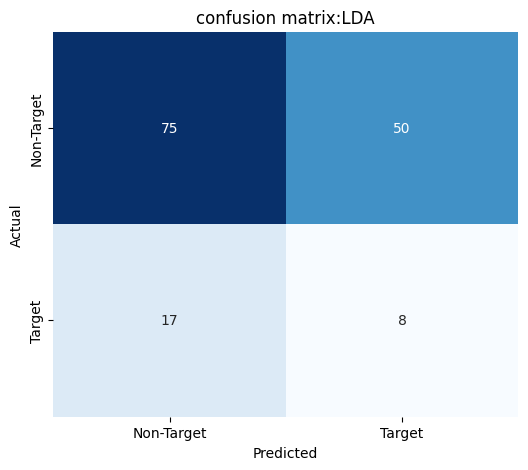

logistic regression classifier trained
Logistic Regression Accuracy: 0.5200
Logistic Regression AUC: 0.5130
              precision    recall  f1-score   support

  non-target       0.83      0.54      0.65       125
      target       0.16      0.44      0.23        25

    accuracy                           0.52       150
   macro avg       0.49      0.49      0.44       150
weighted avg       0.72      0.52      0.58       150



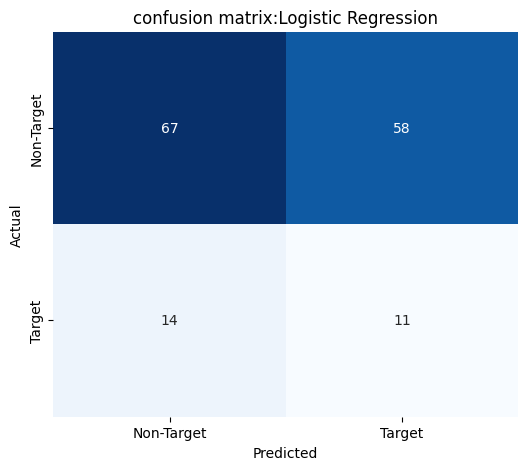

In [ ]:
    # ========================================================================
    # STEP 6: BASELINE CLASSIFIERS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
    print("="*70)

    lda_A = train_lda_classifier(X_train_A, y_train_A)
    acc_lda = evaluate_classifier(lda_A, X_val_A, y_val_A, "LDA")

    lr_A = train_logistic_regression(X_train_A, y_train_A)
    acc_lr = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")


In [ ]:
    # ========================================================================
    # STEP 7: CLASSICAL ML MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
    print("="*70)
    results_classical_A, models_A = compare_all_classical_models(
        X_train_A, y_train_A, X_val_A, y_val_A
    )

    # Train SVM for both subjects (best model)
    svm_A = models_A['SVM'] # Extract SVM from the returned dictionary

    # The train_svm_classifier function returns only the model pipeline, not a separate scaler.
    # So, we should not try to unpack two values here.
    svm_B = train_svm_classifier(X_train_B, y_train_B)



STEP 7: CLASSICAL MACHINE LEARNING (Subject A)

  Training LDA...
lda classifier trained

  Training Logistic Regression...
logistic regression classifier trained

  Training SVM...
SVM classifier trained 

  Training Random Forest...
Random Forest classifier trained

  Training Gradient Boosting...

  Training Gradient Boosting (n_estimators=100)...
gradient boosting trained
                 Model  Accuracy  ROC-AUC
2                  SVM  0.500000  0.60352
1  Logistic Regression  0.520000  0.51296
0                  LDA  0.553333  0.49312
4    Gradient Boosting  0.773333  0.44992
3        Random Forest  0.826667  0.40016
SVM classifier trained 


In [ ]:
    # ========================================================================
    # STEP 8: EXPORT MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: EXPORTING MODELS")
    print("="*70)

    import os
    os.makedirs('models', exist_ok=True)

    # Save pickle
    save_model({
        'model': svm_A,
        'feature_extractor': feature_obj_A
    }, 'models/subject_A_svm.pkl')

    save_model({
        'model': svm_B,
        'feature_extractor': pca_B
    }, 'models/subject_B_svm.pkl')



STEP 8: EXPORTING MODELS

  Model saved to: models/subject_A_svm.pkl

  Model saved to: models/subject_B_svm.pkl
